In [2]:
import os
os.environ['PROJ_LIB'] = r'C:\Users\Zahra\Anaconda3\pkgs\proj4-5.2.0-ha925a31_1\Library\share'

In [3]:
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
import pgeocode
import geopandas as gpd
from shapely.geometry import Point
from fiona.crs import from_epsg
import matplotlib.pylab as plt
from mpl_toolkits.basemap import Basemap
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from descartes import PolygonPatch
import warnings
from IPython.display import clear_output
from IPython import display
from PIL import Image, ImageStat
from io import BytesIO
import time
import random
import math
import ssl
import certifi
random.seed(11)

%pylab inline
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


C:\Users\Zahra\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['display', 'random', 'plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Tableau 10 & Tableau 20 colors as RGB.

In [4]:
tableau10 = [(0, 107, 164), (255, 128, 14), (171, 171, 171), (89, 89, 89),
             (95, 158, 209), (200, 82, 0), (137, 137, 137), (163, 200, 236),
             (255, 188, 121), (207, 207, 207)]

tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]

Scale the RGB values within [0, 1] range for matplotlib.

In [5]:
for i in range(len(tableau10)):  
    r, g, b = tableau10[i]  
    tableau10[i] = (r / 255., g / 255., b / 255.)
    
for i in range(len(tableau20)):
    r, g, b = tableau20[i]
    tableau20[i] = (r / 255., g / 255., b / 255.)

In [8]:
plt.rcParams['figure.figsize'] = 12, 8
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['font.serif'] = 'Arial'
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['axes.titlesize'] = 22
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['figure.frameon'] = False
plt.rcParams['axes.prop_cycle'] = cycler('color',tableau20)
plt.rcParams['legend.frameon'] = False
plt.rcParams['legend.fontsize'] = 14

%config InlineBackend.figure_format = 'retina'

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Load Toronto Airbnb Scraped Data

In [10]:
df = pd.read_csv(r'C:\Users\Zahra\Desktop\insight\GitProjects\insight_project_toronto\data\cleaned\listings.csv')
df.head(5)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21617 entries, 0 to 21616
Columns: 106 entries, id to reviews_per_month
dtypes: float64(24), int64(21), object(61)
memory usage: 17.5+ MB


# Load Surroundings Data of Interest

In [11]:
n = pd.read_csv(r'C:\Users\Zahra\Desktop\insight\GitProjects\insight_project_toronto\data\processed\postal_codes_v.csv')
sub = pd.read_csv(r'C:\Users\Zahra\Desktop\insight\GitProjects\insight_project_toronto\data\cleaned\ttc_stations.csv')
groc = pd.read_csv(r'C:\Users\Zahra\Desktop\insight\GitProjects\insight_project_toronto\data\cleaned\groc.csv')

#noise.info()
#sub.info()
#groc.info()

# Remove listings no longer available online

In [138]:
def notAvail(url):
    """ 
    Flag listings that are no longer available on airbnb. 
  
    Parameters: 
    url: URL of the listing
  
    Returns: 
    1 if listing not available, 0 otherwise.
    """
    page = requests.post(url)
    soup = BeautifulSoup(page.content, "html.parser")
    if soup.title.string == 'Vacation Rentals, Homes, Experiences & Places - Airbnb':
        return 1
    else:
        return 0

start = time.time()
df['noLongerAvail'] = df.listing_url.apply(noAvail)
print ('It took', time.time()-start, 'seconds.')

It took 3864.1005272865295 seconds.


In [141]:
df.to_csv(r'C:\Users\Zahra\Desktop\insight\GitProjects\insight_project_toronto\data\processed\listing_not_available.csv', index=False)

# Determine location of areas w/t frequent noise complaints.

In [8]:
nomi = pgeocode.Nominatim('ca')
noise = nomi.query_postal_code(["M1B","M1C","M1E","M1G","M1H","M1J","M1K","M1L","M1M", "M1N","M1P", 
                       "M1R", "M1S","M1T","M1V","M1W","M1X","M2H","M2J","M2K","M2L","M2M","M2N",
                       "M2P","M2R","M3A","M3B","M3C","M3H","M3J","M3K","M3L","M3M","M3N","M4A","M4B",
                       "M4C","M4E","M4G","M4H","M4J","M4K","M4L","M4M","M4N","M4P","M4S","M4T","M4V", "M4W",
                       "M4X","M4Y","M5A","M5B","M5C","M5E","M5G","M5H","M5J","M5M","M5N","M5P","M5R","M5S","M5T","M5V","M6A", 
                        "M6B","M6C","M6E","M6G","M6H", "M6J","M6K","M6M","M6N","M6P","M6R","M6S","M7A", "M8V", "M8W","M8X","M8Y"
                        "M8Z","M9A","M9B","M9C","M9L","M9M","M9N","M9P","M9P","M9R","M9V","M9W"])
    
noise = noise.to_csv(r'C:\Users\Zahra\Desktop\insight\GitProjects\insight_project_toronto\data\processed\noise.csv', index=False)

# Visualize airbnb listings (43.6532° N, 79.3832° W) in Toronto - including noise, grocery and ttc locations

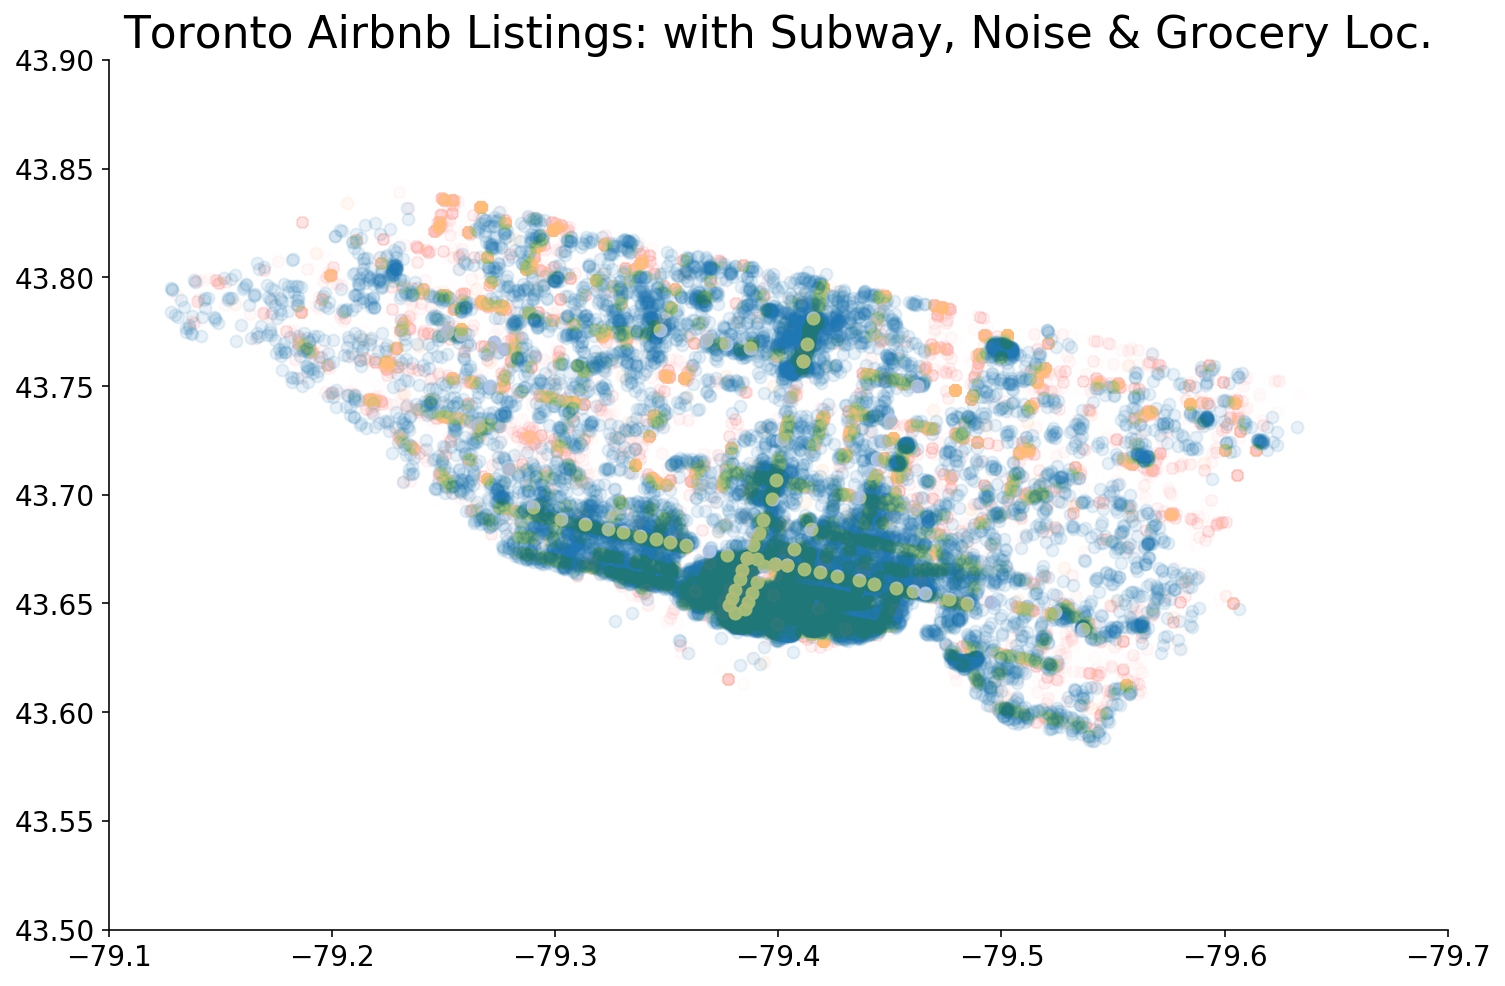

In [13]:
noise = pd.read_csv(r'C:\Users\Zahra\Desktop\insight\GitProjects\insight_project_toronto\data\processed\noise.csv')

plt.scatter(df.longitude, df.latitude, alpha=0.1)
plt.scatter(sub.Longitude, sub.Latitude, alpha=0.9)
plt.scatter(noise.longitude, noise.latitude, alpha=0.05)
plt.scatter(groc.Longitude, groc.Latitude, alpha=.002)
plt.title('Toronto Airbnb Listings: with Subway, Noise & Grocery Loc.')
plt.ylim(43.5,43.9)
plt.xlim(-79.1, -79.7)
plt.show()

# Create Buffer Zone Around Airbnb Listings

In [144]:
# Convert lat/lon to shapely point
df['Coordinates'] = list(zip(df.longitude, df.latitude))
df['Coordinates'] = df['Coordinates'].apply(Point)

# Convert coordinates
dfGeo = gpd.GeoDataFrame(df, crs={'init' :'epsg:4326'}, geometry='Coordinates')

# Walking distance in research is considered one to ten blocks - 400 to 500 m (1/4rth mile):
# Create the 400 m buffer 
count=0
buffers = []
start = time.time()

for point in dfGeo.Coordinates:
    try:
        buffers.append(point.buffer(400/111320.0)) #400 meters
    except:
        buffers.append(np.nan)
    
    count += 1
    if count in np.arange(0,22000,100):
        clear_output()
        print ('Completed %s evaluations'%count)

dfGeo['buffer_km'] = buffers

print ('It took', time.time()-start, 'seconds.')

Completed 21600 evaluations
It took 3.042865514755249 seconds.


Noise Locations to Shapely Points

In [145]:
# convert to shapely points
noise['Coordinates'] = list(zip(noise.longitude, noise.latitude))
noise['Coordinates'] = noise['Coordinates'].apply(Point)

#noise.head(5)

# Convert coordinates
noiseGeo = gpd.GeoDataFrame(noise, crs={'init' :'epsg:4326'}, geometry='Coordinates')

#add
#dfGeo['noise']=noiseGeo['Coordinates']

TTc Entry Locations to Shapely Points

In [146]:
# convert to shapely points
sub['Coordinates'] = list(zip(sub.Longitude, sub.Latitude))
sub['Coordinates'] = sub['Coordinates'].apply(Point)


# Convert coordinates
subGeo = gpd.GeoDataFrame(sub, crs={'init' :'epsg:4326'}, geometry='Coordinates')

#subGeo.info(5)

#add
#dfGeo['sub']=subGeo['Coordinates']

Grocery Locations to Shapely Points

In [147]:
#convert to shapely points
groc['Coordinates'] = list(zip(groc.Longitude, groc.Latitude))
groc['Coordinates'] = groc['Coordinates'].apply(Point)

#groc.shape
#groc.head(5)

# Convert coordinates
grocGeo = gpd.GeoDataFrame(groc, crs={'init' :'epsg:4326'}, geometry='Coordinates')
#grocGeo.head(5)

#add
#dfGeo['groc']=grocGeo['Coordinates']

In [148]:
dfGeo.head(5)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,flag_noLongerAvail,Coordinates,buffer_km
0,1419,https://www.airbnb.com/rooms/1419,20190808195523,2019-08-08,Beautiful home in amazing area!,"This large, family home is located in one of T...",Visit Toronto with this fabulous furnished hom...,"This large, family home is located in one of T...",none,The apartment is located in the Ossington stri...,"To learn a little more about our home, see: (U...",All forms of public transportation are easily ...,The whole house and garden are available.,"We will be out of town, but fully accessible b...",This is our much-loved family home. We expect ...,NaN,NaN,https://a0.muscache.com/im/pictures/76206750/d...,NaN,1565,https://www.airbnb.com/users/show/1565,Alexandra,2008-08-08,"Toronto, Ontario, Canada","I live in Toronto, Canada with my husband and ...",NaN,NaN,NaN,f,https://a0.muscache.com/im/users/1565/profile_...,https://a0.muscache.com/im/users/1565/profile_...,Commercial Drive,1.0,1.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,"Toronto, ON, Canada",Little Portugal,Little Portugal,NaN,Toronto,ON,M6J,Toronto,"Toronto, Canada",CA,Canada,43.64617,-79.42451,f,House,Entire home/apt,10,3.0,5.0,7.0,Real Bed,"{TV,Internet,Wifi,""Air conditioning"",Kitchen,""...",1400.0,$470.00,"$2,000.00",NaN,"$1,000.00",$150.00,1,$0.00,4,730,4,4,730,730,4.0,730.0,18 months ago,t,0,0,0,0,2019-08-08,7,0,2015-07-19,2017-12-04,100.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,NaN,f,f,strict_14_with_grace_period,f,f,1,1,0,0,0.14,0,POINT (-79.42451 43.64617),"POLYGON ((-79.42091675530003 43.64617, -79.420..."
1,8077,https://www.airbnb.com/rooms/8077,20190808195523,2019-08-09,Downtown Harbourfront Private Room,Guest room in a luxury condo with access to al...,My husband and I are both artists. I give pain...,Guest room in a luxury condo with access to al...,none,NaN,NaN,NaN,NaN,NaN,No smoking please.,NaN,NaN,https://a0.muscache.com/im/pictures/11780344/1...,NaN,22795,https://www.airbnb.com/users/show/22795,Kathie & Larry,2009-06-22,"Toronto, Ontario, Canada",My husband and I have been airbnb host for alm...,NaN,NaN,NaN,f,https://a0.muscache.com/im/pictures/9a077853-c...,https://a0.muscache.com/im/pictures/9a077853-c...,Harbourfront,2.0,2.0,"['email', 'phone', 'facebook', 'reviews']",t,f,"Toronto, ON, Canada",

# CHECK IF NOISE, SUBWAY AND GROCERY POINTS LIE WITHIN BUFFER ZONE OF AIRBNB LISTINGS

In [150]:
from shapely.geometry import polygon

df_s = []
df_ss= []
df_n = []
df_nn= []
df_g = []
df_gg= []
count = 0
start = time.time()

for b in dfGeo.buffer_km:
    for s in subGeo['Coordinates']:
        #count = count +1
        #print (count)
        if b.contains(s): 
            df_s.append(1)
        else: 
            df_s.append(0)
        #print(df_s)
    df_ss.append(max(df_s))
    #print(df_ss)
    df_s = []
    
    for g in grocGeo['Coordinates']:
        #count = count +1
        #print (count)
        if b.contains(g): 
            df_g.append(1)
        else: 
            df_g.append(0)
        #print(dg_s)
    df_gg.append(max(df_g))
    #print(df_ss)
    df_g = []
    
    count += 1
    if count in np.arange(0,22000,100):
        clear_output()
        print ('Completed %s buffer_zones'%count)
    
print ('It took', time.time()-start, 'seconds.')        

Completed 21600 buffer_zones
It took 9508.093471050262 seconds.


In [149]:
df_n1 = []
df_nn1= []
start = time.time()

# Noise distance is often considered till 10-25m:

count=0
buffers_noise = []
start = time.time()

for point in dfGeo.Coordinates:
    try:
        buffers_noise.append(point.buffer(25/111320.0)) 
    except:
        buffers_noise.append(np.nan)

dfGeo['buffer_km_noise'] = buffers_noise

for b in dfGeo.buffer_km_noise:
    for n1 in noiseGeo['Coordinates']:
        #count = count +1
        #print (count)
        if b.contains(n1): 
            df_n1.append(1)
        else: 
            df_n1.append(0)
        #print(df_s)
    df_nn1.append(max(df_n1))
    #print(df_nn)
    df_n1 = []
    
    count += 1
    if count in np.arange(0,22000,100):
        clear_output()
        print ('Completed %s evaluations'%count)
    
print ('It took', time.time()-start, 'seconds.')

Completed 21600 evaluations
It took 17.837672472000122 seconds.


In [151]:
dfGeo['close_sub'] = df_ss
dfGeo['close_noise'] = df_nn1
dfGeo['close_groc'] = df_gg

In [152]:
dfGeo.head(5)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,flag_noLongerAvail,Coordinates,buffer_km,buffer_km_noise,close_sub,close_noise,close_groc
0,1419,https://www.airbnb.com/rooms/1419,20190808195523,2019-08-08,Beautiful home in amazing area!,"This large, family home is located in one of T...",Visit Toronto with this fabulous furnished hom...,"This large, family home is located in one of T...",none,The apartment is located in the Ossington stri...,"To learn a little more about our home, see: (U...",All forms of public transportation are easily ...,The whole house and garden are available.,"We will be out of town, but fully accessible b...",This is our much-loved family home. We expect ...,NaN,NaN,https://a0.muscache.com/im/pictures/76206750/d...,NaN,1565,https://www.airbnb.com/users/show/1565,Alexandra,2008-08-08,"Toronto, Ontario, Canada","I live in Toronto, Canada with my husband and ...",NaN,NaN,NaN,f,https://a0.muscache.com/im/users/1565/profile_...,https://a0.muscache.com/im/users/1565/profile_...,Commercial Drive,1.0,1.0,"['email', 'phone', 'reviews', 'jumio', 'govern...",t,t,"Toronto, ON, Canada",Little Portugal,Little Portugal,NaN,Toronto,ON,M6J,Toronto,"Toronto, Canada",CA,Canada,43.64617,-79.42451,f,House,Entire home/apt,10,3.0,5.0,7.0,Real Bed,"{TV,Internet,Wifi,""Air conditioning"",Kitchen,""...",1400.0,$470.00,"$2,000.00",NaN,"$1,000.00",$150.00,1,$0.00,4,730,4,4,730,730,4.0,730.0,18 months ago,t,0,0,0,0,2019-08-08,7,0,2015-07-19,2017-12-04,100.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,NaN,f,f,strict_14_with_grace_period,f,f,1,1,0,0,0.14,0,POINT (-79.42451 43.64617),"POLYGON ((-79.42091675530003 43.64617, -79.420...","POLYGON ((-79.42226422206252 43.64617, -79.422...",0,0,1
1,8077,https://www.airbnb.com/rooms/8077,20190808195523,2019-08-09,Downtown Harbourfront Private Room,Guest room in a luxury condo with access to al...,My husband and I are both artists. I give pain...,Guest room in a luxury condo with access to al...,none,NaN,NaN,NaN,NaN,NaN,No smoking please.,NaN,NaN,https://a0.muscache.com/im/pictures/11780344/1...,NaN,22795,https://www.airbnb.com/users/show/22795,Kathie & Larry,2009-06-22,"Toronto, Ontario, Canada",My husband and I have been airbnb host for alm...,NaN,NaN,NaN,f,https://a0.muscache.com/im/pictures/9a077853-c...,https://a0.muscache.com/im/picture

In [153]:
dfGeo.to_csv(r'C:\Users\Zahra\Desktop\insight\GitProjects\insight_project_toronto\data\processed\close_.csv', index=False)

In [154]:
combo=pd.read_csv(r'C:\Users\Zahra\Desktop\insight\GitProjects\insight_project_toronto\data\processed\close_.csv')

In [155]:
combo.to_csv(r'C:\Users\Zahra\Desktop\insight\GitProjects\insight_project_toronto\data\processed\combo.csv', index=False)